# IMDB revisited

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_words = 10000
max_len = 2500 # just over max review length
print('Loading data...')
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=max_words)
print(len(x_train), 'train sequences')
print(len(x_val), 'validation sequences')
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_val = sequence.pad_sequences(x_val, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)

Using TensorFlow backend.


Loading data...
25000 train sequences
25000 validation sequences
Pad sequences (samples x time)
x_train shape: (25000, 2500)
x_val shape: (25000, 2500)


Next I set up model. I've changed the model in the notes as follows:
* Set `max_len` to 2500, which is enough to contain all the complete reviews.

And to reduce overfitting:
* Used dropout
* Used weight penalisation. This was particularly effective in the embedding layer (I guess this discouraged memorisation of combinations of rare words). I used L2 penalisation and tanh activations as these are resistant to heavy penalisation i.e. network doesn't collapse down to all weights being zero so easily.
* Reduced number of layers and units in the model (this also speeds up training!)
* Used a global pooling layer: this pools across all whole length of the sequence

In [2]:
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
model = models.Sequential()
reg = regularizers.l2(0.001)
model.add(layers.Embedding(max_words, 16, input_length=max_len, embeddings_regularizer=reg))
layers.Dropout(0.2)
model.add(layers.Conv1D(16, 7, activation="tanh", padding="same", kernel_regularizer=reg))
model.add(layers.MaxPooling1D(5))
layers.Dropout(0.5)
model.add(layers.Conv1D(8, 7, activation="tanh", padding="same", kernel_regularizer=reg))
model.add(layers.GlobalMaxPooling1D())
layers.Dropout(0.5)
model.add(layers.Dense(1, activation="sigmoid", kernel_regularizer=reg))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2500, 16)          160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2500, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 8)            904       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,721
Trainable params: 162,721
Non-trainable params: 

In [3]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["acc"])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 68s 3ms/step - loss: 0.6893 - acc: 0.6254 - val_loss: 0.5108 - val_acc: 0.7983
Epoch 2/10
25000/25000 [==============================] - 68s 3ms/step - loss: 0.4488 - acc: 0.8431 - val_loss: 0.4274 - val_acc: 0.8537
Epoch 3/10
25000/25000 [==============================] - 68s 3ms/step - loss: 0.3770 - acc: 0.8882 - val_loss: 0.4154 - val_acc: 0.8616
Epoch 4/10
25000/25000 [==============================] - 74s 3ms/step - loss: 0.3452 - acc: 0.9094 - val_loss: 0.4136 - val_acc: 0.8661
Epoch 5/10
25000/25000 [==============================] - 70s 3ms/step - loss: 0.3235 - acc: 0.9237 - val_loss: 0.4219 - val_acc: 0.8675
Epoch 6/10
25000/25000 [==============================] - 71s 3ms/step - loss: 0.3141 - acc: 0.9277 - val_loss: 0.4309 - val_acc: 0.8644
Ep

In [4]:
import matplotlib.pyplot as plt

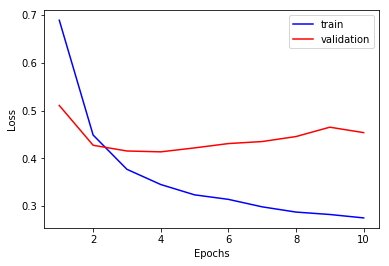

In [5]:
history_dict = history.history
train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, "b-", label="train")
plt.plot(epochs, val_loss, "r-", label="validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

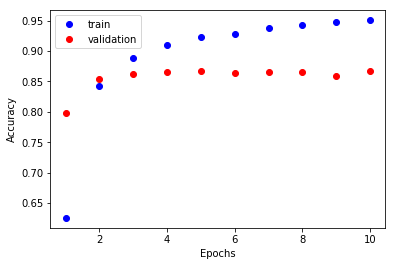

In [6]:
train_acc = history_dict["acc"]
test_acc = history_dict["val_acc"]
plt.plot(epochs, train_acc, "bo", label="train")
plt.plot(epochs, test_acc, "ro", label="validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

This network is more resistant to overfitting than the example of 10.2 although its best validation performance is similar. Overfitting is still a problem, as we can see by the training loss being better than the validation loss in later epochs. To improve further we really need more data!